# Football Style Analysis
## Installation and Setup

In [1]:
# Install required packages
!pip install statsbombpy
!pip install mplsoccer
!pip install highlight_text
!pip install networkx
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached mplsoccer-1.5.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached scipy-1.15.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached mplsoccer-1.5.0-py3-none-any.whl (86 kB)
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
    --------------------------------------- 0.5/41.0 MB 3.4 MB/s eta 0:00:12
   - -------------------------------------- 1.3/41.0 MB 3.3 MB/s eta 0:00:12
   - -------------------------------------- 1.8/41.0 MB 3.4 MB/s eta 0:00:12
   -- ------------------------------------- 2.6/41.0 MB 3.3 MB/s eta 0:00:12
   --- ------------------------------------ 3.1/41.0 MB 3.3 MB/s eta 0:00:12
   --- ------------------------------------ 3.9/41.0 MB 3.3 MB/s eta 0:00:12
   ---- ----------------------------------- 4.7/41.0 MB 3.3 MB/s eta 0:00:12
   ----- ---------------------------------- 5.2/41.0 MB 3.3 MB/s eta 0:00:11
   ----- ---------------------------------- 6.0/41.0 MB 3.


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 2.8 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.0 MB 3.4 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/2.0 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 3.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.7 MB 3.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/10.7 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/10.7 MB 3.2 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/10.7 MB 3.2 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/10.7 MB 3.2 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/10.7 MB 3.3 MB/s eta 0:00:03
   ---------------- ----------------------- 4.5/10.7 MB 3.3 MB/s eta 0:00:02
   ------------------- -------------------- 5.2/10.7 MB 3.3 MB/s eta 0:00:02
   ---------------------- ----------------- 6.0/10.7 MB 3.3 MB/s eta 0:00:02
   ------------------------ --------------- 6.6/10.7 MB 3.2 MB/s eta 0:00:02
   --------------------------- ------------ 7.3/10.7 MB 3.2 MB/s eta 0:00:02
   ----------------------------- ---------- 7.9/10.7 MB 3.2 MB/s eta 0:00:01
   ---


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import packages
from statsbombpy import sb
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch, Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [3]:
# Load Competition Data
free_comps = sb.competitions()
laliga_seasons = free_comps[free_comps['competition_id'] == 11]

# Create list to store all La Liga seasons' matches
all_laliga_matches = []

# Fetch matches for each season
for i, season in laliga_seasons.iterrows():
    comp_id = season['competition_id']
    season_id = season['season_id']
    season_name = season['season_name']
    print(f"Fetching matches for {season_name} season...")
    try:
        matches = sb.matches(competition_id=comp_id, season_id=season_id)
        matches['season_name'] = season_name
        all_laliga_matches.append(matches)
    except Exception as e:
        print(f"Error fetching {season_name}: {str(e)}")

all_matches_df = pd.concat(all_laliga_matches, ignore_index=True)
print(f"\nTotal seasons collected: {len(all_laliga_matches)}")
print(f"Total matches: {len(all_matches_df)}")

Fetching matches for 2020/2021 season...
Fetching matches for 2019/2020 season...
Fetching matches for 2018/2019 season...
Fetching matches for 2017/2018 season...
Fetching matches for 2016/2017 season...
Fetching matches for 2015/2016 season...
Fetching matches for 2014/2015 season...
Fetching matches for 2013/2014 season...
Fetching matches for 2012/2013 season...
Fetching matches for 2011/2012 season...
Fetching matches for 2010/2011 season...
Fetching matches for 2009/2010 season...
Fetching matches for 2008/2009 season...
Fetching matches for 2007/2008 season...
Fetching matches for 2006/2007 season...
Fetching matches for 2005/2006 season...
Fetching matches for 2004/2005 season...
Fetching matches for 1973/1974 season...

Total seasons collected: 18
Total matches: 868


## Style Analysis Class

In [7]:
class StyleAnalyzer:
    def __init__(self, team_name):
        self.team = team_name
        self.matches_df = None
        self.events_df = None
        
    def load_team_matches(self, all_matches):
        """Load and process team matches"""
        self.matches_df = all_matches[
            (all_matches['home_team'] == self.team) |
            (all_matches['away_team'] == self.team)
        ].sort_values('match_date', ascending=True)
        
        # Add result and goal difference columns
        self.matches_df['result'] = self.matches_df.apply(
            lambda x: 'Win' if ((x['home_team'] == self.team and x['home_score'] > x['away_score']) |
                               (x['away_team'] == self.team and x['away_score'] > x['home_score']))
                      else 'Loss' if ((x['home_team'] == self.team and x['home_score'] < x['away_score']) |
                                    (x['away_team'] == self.team and x['away_score'] < x['home_score']))
                      else 'Draw', axis=1
        )
        
        self.matches_df['goal_diff'] = self.matches_df.apply(
            lambda x: x['home_score'] - x['away_score'] if x['home_team'] == self.team
                      else x['away_score'] - x['home_score'], axis=1
        )
        
    def load_match_events(self, match_id):
        """Load events for a specific match"""
        events = sb.events(match_id=match_id)
        
        # Process location data
        events[['x', 'y']] = events['location'].apply(pd.Series)
        events[['pass_end_x', 'pass_end_y']] = events['pass_end_location'].apply(pd.Series)
        events[['carry_end_x', 'carry_end_y']] = events['carry_end_location'].apply(pd.Series)
        
        self.events_df = events
        return events
    
    def calculate_possession_metrics(self, events):
        """Calculate possession-related metrics"""
        team_events = events[events['team'] == self.team]
        
        # Calculate possession percentage
        total_duration = events['duration'].sum()
        team_duration = team_events['duration'].sum()
        possession_pct = (team_duration / total_duration) * 100
        
        # Calculate passing metrics
        team_passes = team_events[team_events['type'] == 'Pass']
        completed_passes = team_passes[team_passes['pass_outcome'].isna()]
        pass_completion = (len(completed_passes) / len(team_passes)) * 100
        
        # Calculate progressive passes
        def is_progressive(row):
            if pd.isna(row['pass_end_x']) or pd.isna(row['x']):
                return False
            return (row['pass_end_x'] - row['x']) > 10
            
        progressive_passes = team_passes[team_passes.apply(is_progressive, axis=1)]
        
        return {
            'possession_pct': possession_pct,
            'pass_completion': pass_completion,
            'total_passes': len(team_passes),
            'progressive_passes': len(progressive_passes)
        }
    
    def calculate_pressing_metrics(self, events):
        """Calculate pressing-related metrics"""
        opposition_events = events[events['team'] != self.team]
        
        # Calculate PPDA (Passes Per Defensive Action)
        opposition_passes = len(opposition_events[opposition_events['type'] == 'Pass'])
        defensive_actions = len(events[
            (events['team'] == self.team) &
            (events['type'].isin(['Pressure', 'Tackle', 'Interception']))
        ])
        
        ppda = opposition_passes / defensive_actions if defensive_actions > 0 else float('inf')
        
        # Calculate high turnovers
        high_turnovers = len(events[
            (events['team'] == self.team) &
            (events['type'].isin(['Ball Recovery', 'Interception'])) &
            (events['y'] >= 70)
        ])
        
        return {
            'ppda': ppda,
            'high_turnovers': high_turnovers
        }
    
    def calculate_attacking_metrics(self, events):
        """Calculate attacking-related metrics"""
        team_events = events[events['team'] == self.team]
        
        # Calculate crosses
        crosses = len(team_events[
            (team_events['type'] == 'Pass') &
            (team_events['pass_type'] == 'Cross')
        ])
        
        # Calculate through balls
        through_balls = len(team_events[
            (team_events['type'] == 'Pass') &
            (team_events['pass_type'] == 'Through Ball')
        ])
        
        # Calculate shots and xG
        shots = team_events[team_events['type'] == 'Shot']
        total_xg = shots['shot_statsbomb_xg'].sum()
        
        return {
            'crosses': crosses,
            'through_balls': through_balls,
            'shots': len(shots),
            'xg': total_xg
        }
    
    def visualize_pass_network(self, events, ax=None):
        """Create pass network visualization"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))
            
        team_passes = events[
            (events['team'] == self.team) &
            (events['type'] == 'Pass')
        ]
        
        # Create network graph
        G = nx.Graph()
        
        # Add nodes (players)
        player_positions = {}
        for player in team_passes['player'].unique():
            player_events = team_passes[team_passes['player'] == player]
            avg_x = player_events['x'].mean()
            avg_y = player_events['y'].mean()
            player_positions[player] = (avg_x, avg_y)
            G.add_node(player)
            
        # Add edges (passes between players)
        pass_counts = {}
        for _, pass_event in team_passes.iterrows():
            if pd.notna(pass_event['pass_recipient']):
                player_pair = tuple(sorted([pass_event['player'], pass_event['pass_recipient']]))
                pass_counts[player_pair] = pass_counts.get(player_pair, 0) + 1
                
        for (player1, player2), weight in pass_counts.items():
            G.add_edge(player1, player2, weight=weight)
            
        # Draw the network
        pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
        pitch.draw(ax=ax)
        
        nx.draw(G, pos=player_positions, with_labels=True, node_color='red',
                node_size=500, edge_color='white', width=[d['weight']/5 for (u,v,d) in G.edges(data=True)],
                ax=ax)
        
        return ax
    
    def create_style_radar(self, metrics, ax=None):
        """Create radar chart for style metrics"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
            
        # Prepare data
        categories = list(metrics.keys())
        values = list(metrics.values())
        
        # Number of variables
        num_vars = len(categories)
        
        # Compute angle for each axis
        angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
        angles += angles[:1]
        
        # Initialize the plot
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        
        # Draw the axes
        plt.xticks(angles[:-1], categories)
        
        # Plot data
        values += values[:1]
        ax.plot(angles, values)
        ax.fill(angles, values, alpha=0.25)
        
        return ax

## Analysis Example

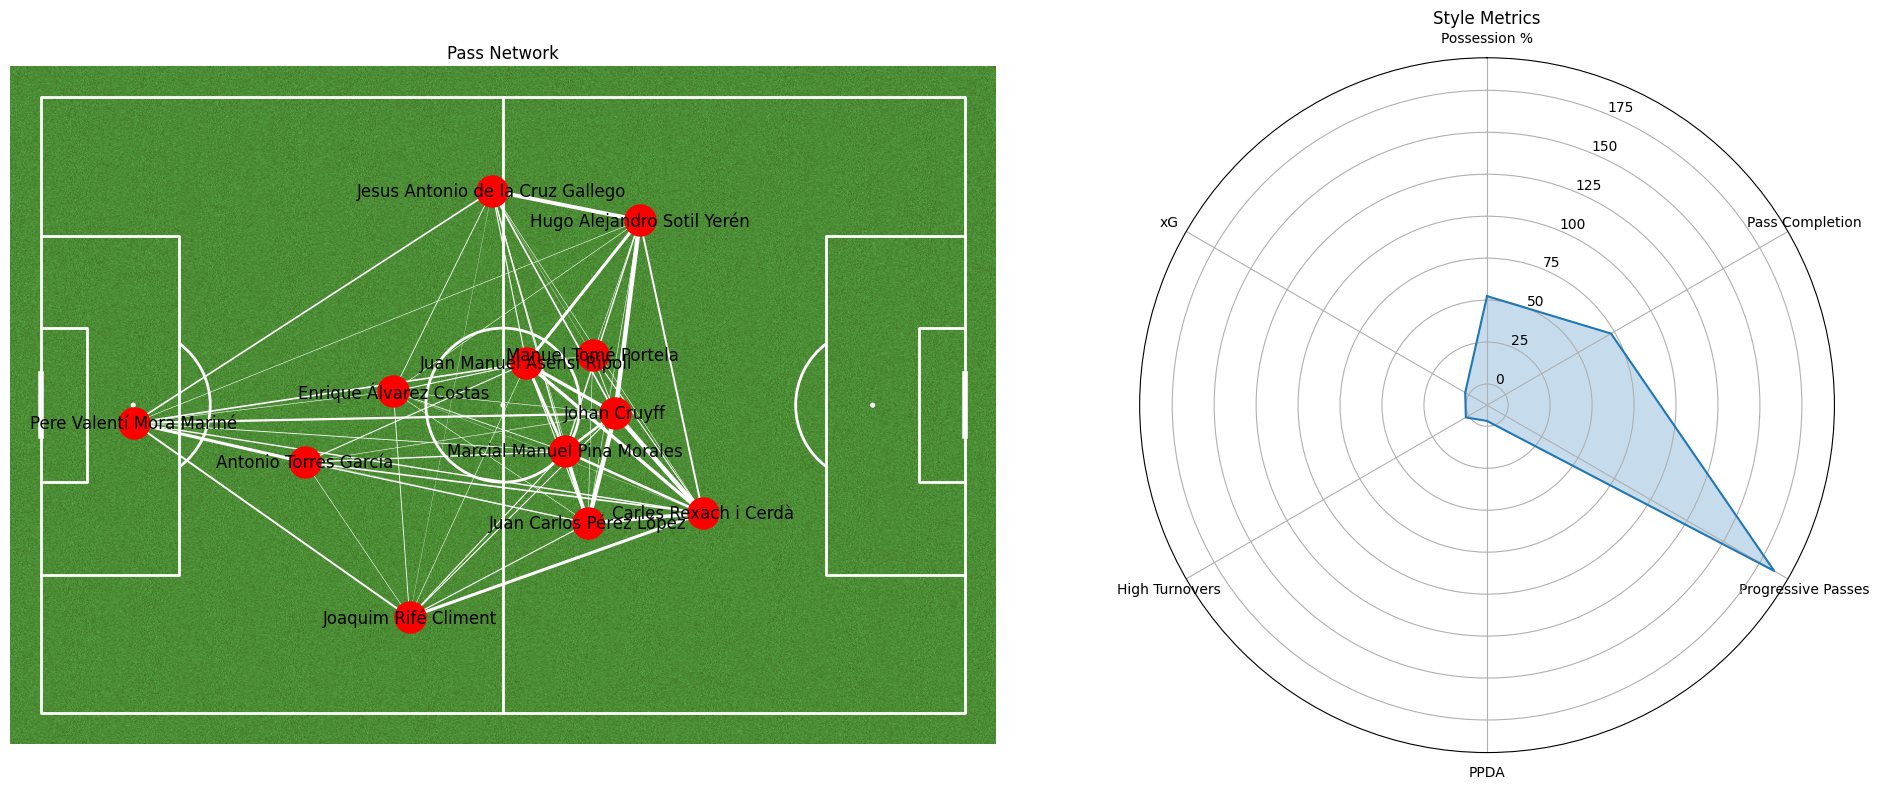

In [10]:
# Initialize analyzer for Barcelona
analyzer = StyleAnalyzer("Barcelona")
analyzer.load_team_matches(all_matches_df)

# Get latest match events
latest_match_id = analyzer.matches_df.iloc[0]['match_id']
events = analyzer.load_match_events(latest_match_id)

# Calculate metrics
possession_metrics = analyzer.calculate_possession_metrics(events)
pressing_metrics = analyzer.calculate_pressing_metrics(events)
attacking_metrics = analyzer.calculate_attacking_metrics(events)

# Create visualizations
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='polar')

# Pass network
analyzer.visualize_pass_network(events, ax=ax1)
ax1.set_title('Pass Network')

# Style radar
metrics_for_radar = {
    'Possession %': possession_metrics['possession_pct'],
    'Pass Completion': possession_metrics['pass_completion'],
    'Progressive Passes': possession_metrics['progressive_passes'],
    'PPDA': -pressing_metrics['ppda'],  # Negative since lower PPDA means more pressing
    'High Turnovers': pressing_metrics['high_turnovers'],
    'xG': attacking_metrics['xg']
}

analyzer.create_style_radar(metrics_for_radar, ax=ax2)
ax2.set_title('Style Metrics')

plt.tight_layout()
plt.show()

## Style Evolution Analysis

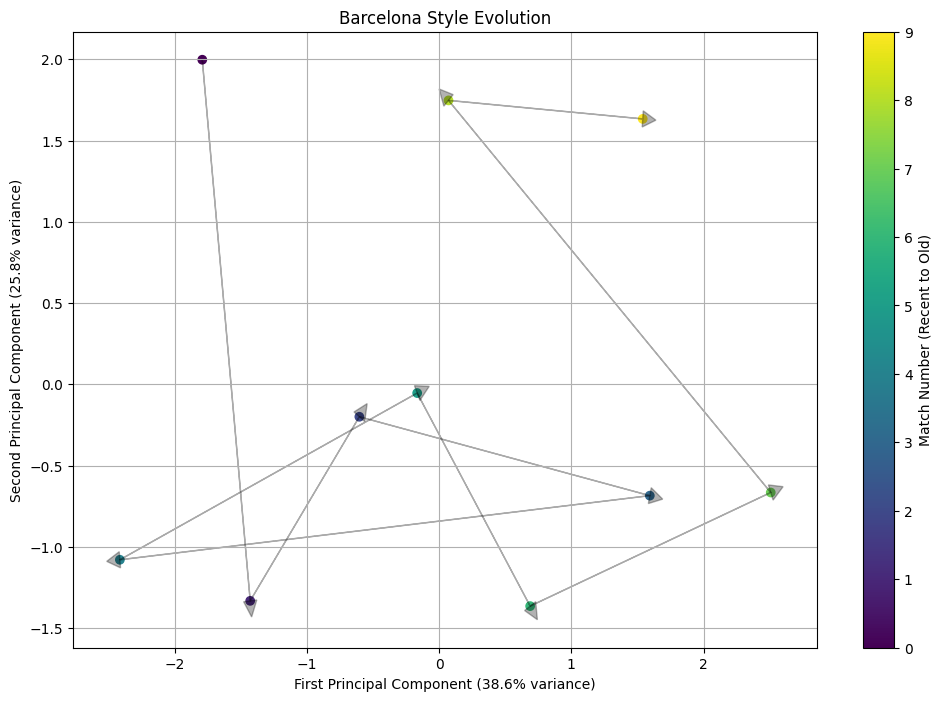


Feature Importance in Principal Components:
                         PC1       PC2
possession_pct      0.558199 -0.234416
pass_completion     0.625843 -0.079755
progressive_passes  0.362539 -0.297849
ppda               -0.386695 -0.494283
high_turnovers     -0.051492 -0.352464
crosses             0.000000  0.000000
through_balls       0.000000  0.000000
xg                  0.114523  0.693850


In [8]:
# Collect metrics across multiple matches
def collect_match_metrics(analyzer, num_matches=10):
    all_metrics = []
    
    for _, match in analyzer.matches_df.head(num_matches).iterrows():
        match_id = match['match_id']
        events = analyzer.load_match_events(match_id)
        
        possession = analyzer.calculate_possession_metrics(events)
        pressing = analyzer.calculate_pressing_metrics(events)
        attacking = analyzer.calculate_attacking_metrics(events)
        
        metrics = {
            'match_date': match['match_date'],
            'possession_pct': possession['possession_pct'],
            'pass_completion': possession['pass_completion'],
            'progressive_passes': possession['progressive_passes'],
            'ppda': pressing['ppda'],
            'high_turnovers': pressing['high_turnovers'],
            'crosses': attacking['crosses'],
            'through_balls': attacking['through_balls'],
            'xg': attacking['xg']
        }
        
        all_metrics.append(metrics)
    
    return pd.DataFrame(all_metrics)

# Collect metrics for recent matches
metrics_df = collect_match_metrics(analyzer)

# Prepare data for PCA
features = ['possession_pct', 'pass_completion', 'progressive_passes',
           'ppda', 'high_turnovers', 'crosses', 'through_balls', 'xg']

X = metrics_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create style evolution plot
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=range(len(X_pca)), cmap='viridis')
plt.colorbar(label='Match Number (Recent to Old)')

# Add arrows to show evolution
for i in range(len(X_pca)-1):
    plt.arrow(X_pca[i, 0], X_pca[i, 1],
              X_pca[i+1, 0] - X_pca[i, 0],
              X_pca[i+1, 1] - X_pca[i, 1],
              head_width=0.1, head_length=0.1, fc='k', ec='k', alpha=0.3)

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'{analyzer.team} Style Evolution')
plt.grid(True)
plt.show()

# Print feature importance
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=features
)
print("\nFeature Importance in Principal Components:")
print(feature_importance)